In [12]:
# Import utility/mother of Python packages
import pandas as pd
import numpy as np

# Imported PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import random
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# All images stored in CNN_Data/CNN
# Collected by Carlie

In [13]:
# Clara
# Set seeds
random.seed(2025)
np.random.seed(2025)
torch.manual_seed(2025)

In [14]:
# Clara
# Lists to store metrics so they can be graphed later on.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
all_predictions = []
all_labels = []

In [15]:
# Clara
# A generic resizing function that resizes images appropriately in 500 x 500
transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])

In [16]:
# Clara
# # Adjust dataset based upon specifications of the project.
dataset = datasets.ImageFolder('CNN_Data/CNN', transform=transform)

In [17]:
# Clara
# Grab number of classes within the dataset based on the directory structure
num_classes = len(dataset.classes)
print(f"{num_classes} classes: {dataset.classes}")
print(f"Total images: {len(dataset)}")

2 classes: ['official_razorback', 'other']
Total images: 60


In [18]:
# Clara
# Utilizing an 80/20 training-test split, mostly because of the small dataset size.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [19]:
# Clara
# Create dataloaders based on the train and test datasets.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
# Clara
# Print the quantities of images.
# Training is super close to 50, which is nice.
print(f"Training images: {train_size}")
print(f"Testing images: {test_size}\n")

Training images: 48
Testing images: 12



In [21]:
# Clara
# Define baseline CNN moddel. No frills.
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Layer 1: Find basic features like edges and colors.
        # Three input chhannels, with 32 feature maps. 
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Slash the image in half.
        self.pool = nn.MaxPool2d(2, 2)
        
        # Layer 2: Textures, object parts
        # 32 channels, 64 feature maps
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Layer 3: Even further razorback detail
        # 64 input channels, 128 feature maps.
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Combine all the features together to make a finalized prediction of razorback or not razorback.

        # Layer 4: Combine everything to make predictions
        # An output of 265 neurons, where 495,872 flattened features are fed as input
        self.fc1 = nn.Linear(128 * 62 * 62, 256)

        # The final output later with 265 neurons, and two classes
        # Stuff it into a fully connected layer 2 variable. 
        self.fc2 = nn.Linear(256, num_classes)

        # So basically:
        # fc1 = 495,872 to 256.
        # fc2 = 256 to 2.
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):

        # Done to extract features out of dataset, passing each image through the network. 
        x = self.pool(F.relu(self.conv1(x)))  # 500 x 500 to 250 x 250
        
        # Pass through conv layer 2
        x = self.pool(F.relu(self.conv2(x)))  # 250 x 250 to 125 x 125
        
        # Pass through conv layer 3
        x = self.pool(F.relu(self.conv3(x)))  # 125 x 125 to 62 x 62
        
        # Right now the feature maps are three dimensional. Make them one dimensional.
        x = x.view(-1, 128 * 62 * 62)
        
        # Final classification layers

        # Take all of the flattened features, pass them through the fully connected layer, and output 256 numbers. 
        # Apply ReLU to those numbers, where if the numbers are negative, they are zero'd. 
        x = F.relu(self.fc1(x))

        # Remember dropout is 0.5, so 50% of values are set to zero. 
        x = self.dropout(x)

        # Take all neurons, make the final predictions.
        x = self.fc2(x)
        
        return x

In [22]:
# Clara
# Create the model
model = SimpleCNN(num_classes=num_classes)

In [23]:
# Clara
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [24]:
# Clara
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # 0.001 is a good default. Can be tuned, of course.

In [25]:
# Clara
# Define the training function
def train(num_epochs=10):
    model.train()
    
    # Clear previous metrics
    train_losses.clear()
    train_accuracies.clear()
    
    for epoch in range(num_epochs): # For all the epochs
        total_loss = 0 # Track the sum of all losses.
        correct = 0 # And correct predictions.
        total = 0 # And the image seen.
        
        for batch_num, (images, labels) in enumerate(train_loader):
            # Move data to GPU/CPU
            images = images.to(device)
            labels = labels.to(device)
            
            # Clear previous gradients
            optimizer.zero_grad()
            
            # Make predictions
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Update weights
            loss.backward()
            optimizer.step()
            
            # Track accuracy
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Save metrics
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        
        # Print results for this epoch
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [26]:
# Clara
# Train the model. Observe that the accuracies aren't bad.
train()

Epoch 1/10 - Train Loss: 6.1904, Train Accuracy: 52.08%
Epoch 2/10 - Train Loss: 5.5902, Train Accuracy: 47.92%
Epoch 3/10 - Train Loss: 0.8004, Train Accuracy: 58.33%
Epoch 4/10 - Train Loss: 0.6089, Train Accuracy: 66.67%
Epoch 5/10 - Train Loss: 0.5386, Train Accuracy: 68.75%
Epoch 6/10 - Train Loss: 0.5099, Train Accuracy: 68.75%
Epoch 7/10 - Train Loss: 0.4287, Train Accuracy: 77.08%
Epoch 8/10 - Train Loss: 0.3741, Train Accuracy: 83.33%
Epoch 9/10 - Train Loss: 0.2678, Train Accuracy: 89.58%
Epoch 10/10 - Train Loss: 0.2774, Train Accuracy: 91.67%


In [27]:
# Clara
# Test model now.
def test():

    # Put model in eval mode so there's no dropout, no weight updates, ect.
    model.eval()
    
    # Exceedingly similar to the above
    correct = 0
    total = 0
    test_loss = 0
    
    # Clear previous predictions
    all_predictions.clear()
    all_labels.clear()
    
    with torch.no_grad(): # No gradients needed, we are testing.
        for images, labels in test_loader: # For all the test images.
            images = images.to(device) # Move the data to the devices.
            labels = labels.to(device)
            
            outputs = model(images) # Throw images into the CNN and get predictions.
            loss = criterion(outputs, labels) # Grab the loss values.
            
            test_loss += loss.item() # Accumulate up the loss so they can be used later.
            _, predicted = torch.max(outputs, 1) # Don't go crazy: Just get the highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Count the true predictions.
            
            # Save for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy metrics for the entire run.
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    # Save test metrics
    test_losses.append(avg_loss)
    test_accuracies.append(accuracy)
    
    print("Results of the testing:")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Correct: {correct}/{total}")

In [28]:
# Clara
# Test
test()

Results of the testing:
Test Loss: 0.7756
Test Accuracy: 58.33%
Correct: 7/12


In [ ]:
def show_graphs():
    # Initiate the plotting landscape
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss graph
    # For all the epoches that are gone through.
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss Over Time')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy graph.
    ax2.plot(epochs, train_accuracies, 'g-', label='Training Accuracy', linewidth=2)
    if test_accuracies:
        ax2.axhline(y=test_accuracies[-1], color='r', linestyle='--', 
                   label=f'Test Accuracy: {test_accuracies[-1]:.2f}%', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy Over Time')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Add some accuracy tickers for clarity below the graphs. 
    print("\nFinal Results:")
    print(f"Best Training Accuracy: {max(train_accuracies):.2f}%")
    if test_accuracies:
        print(f"Test Accuracy: {test_accuracies[-1]:.2f}%")

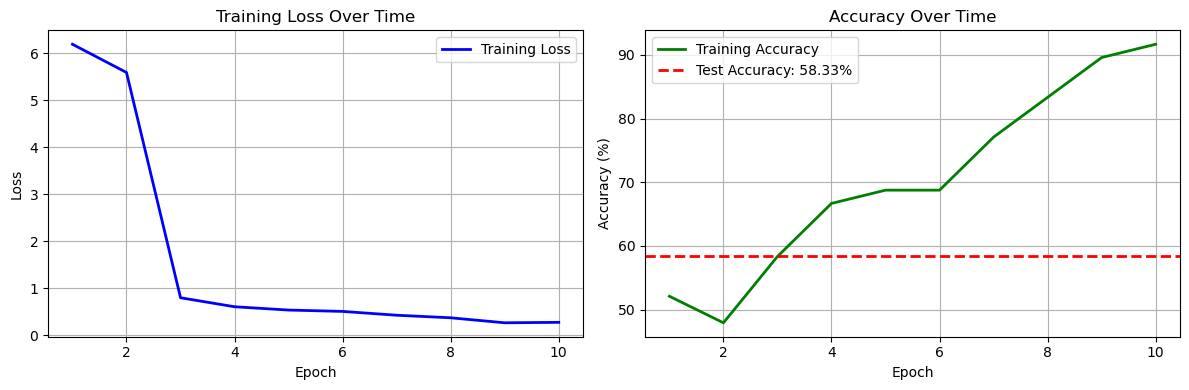


Final Results:
Best Training Accuracy: 91.67%
Test Accuracy: 58.33%


In [31]:
show_graphs()

In [34]:
# Clara
# Show a confusion matrix of the test set.
def show_confusion_matrix():
    if not all_predictions:
        print("Run the darn function.")
        return
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=dataset.classes, 
                yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

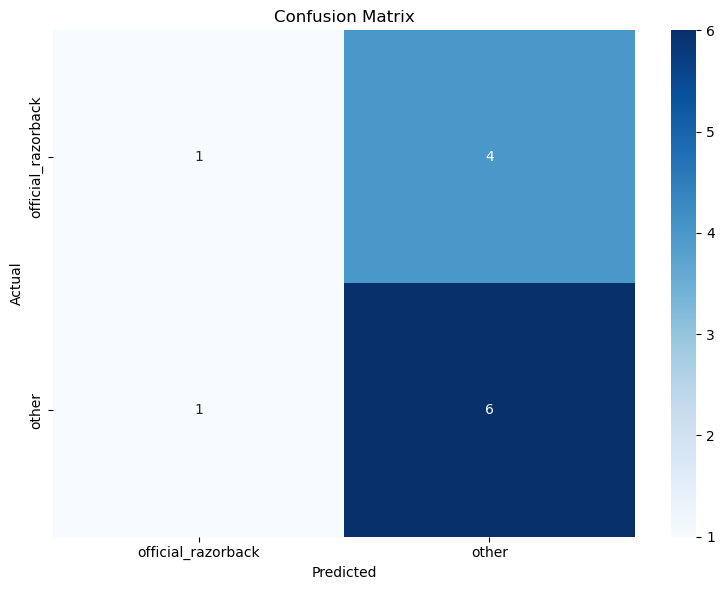

In [35]:
show_confusion_matrix()

In [36]:
#  Carlie
# A fancier augmentation pipeline.

# Resize images to 500 x 500
IMG_SIZE = 500

def get_transforms(use_normalization: bool):
    if use_normalization:
        train_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        test_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        
    else:
        # try without normalization
        train_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
        ])

        test_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ])

    return train_transform, test_transform

In [37]:
# Carlie
# Carlie try and normalize images - a second one?

IMG_SIZE = 500  

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    # ImageNet normalization (rough but usually fine if you don't know dataset stats)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [38]:
# Carlie
# ???
DATA_DIR = "CNN_Data/CNN"

full_train_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
num_classes = len(full_train_dataset.classes)

# Split
train_size = int(0.75 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, test_size])

# IMPORTANT: override test transform (random_split will copy the same underlying dataset)
test_dataset.dataset.transform = test_transform

In [39]:
DATA_DIR = "CNN_Data/CNN"
BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
RANDOM_SEED = 40

def make_loaders(use_normalization: bool):
    train_transform, test_transform = get_transforms(use_normalization)

    full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
    num_classes = len(full_dataset.classes)

    train_size = int(TRAIN_SPLIT * len(full_dataset))
    test_size = len(full_dataset) - train_size

    torch.manual_seed(RANDOM_SEED)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # important: set test transform on the underlying dataset
    test_dataset.dataset.transform = test_transform

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader, num_classes, full_dataset.classes

In [40]:
# Carlie
def train_one_model(use_normalization: bool, num_epochs: int = 10):
    print("\n==============================")
    print(f"Experiment: use_normalization = {use_normalization}")
    print("==============================")

    train_loader, test_loader, num_classes, class_names = make_loaders(use_normalization)

    # fresh model & optimizer each time
    model = SimpleCNN(num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # final test evaluation
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100.0 * test_correct / test_total
    print(f"Test - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}% "
          f"({test_correct}/{test_total})")

    return model, (train_loss, train_acc), (test_loss, test_acc)


In [41]:
# Carlie
model_no_norm, _, _ = train_one_model(use_normalization=False, num_epochs=10)
model_norm,   _, _ = train_one_model(use_normalization=True,  num_epochs=10)



Experiment: use_normalization = False
Epoch 1/10 - Train Loss: 2.2763, Train Acc: 52.08%
Epoch 2/10 - Train Loss: 8.8806, Train Acc: 52.08%
Epoch 3/10 - Train Loss: 2.0000, Train Acc: 47.92%
Epoch 4/10 - Train Loss: 0.8590, Train Acc: 52.08%
Epoch 5/10 - Train Loss: 0.6698, Train Acc: 64.58%
Epoch 6/10 - Train Loss: 0.6831, Train Acc: 54.17%
Epoch 7/10 - Train Loss: 0.5906, Train Acc: 79.17%
Epoch 8/10 - Train Loss: 0.5130, Train Acc: 85.42%
Epoch 9/10 - Train Loss: 0.4264, Train Acc: 89.58%
Epoch 10/10 - Train Loss: 0.3149, Train Acc: 91.67%
Test - Loss: 0.6523, Acc: 58.33% (7/12)

Experiment: use_normalization = True
Epoch 1/10 - Train Loss: 5.5838, Train Acc: 56.25%
Epoch 2/10 - Train Loss: 21.4189, Train Acc: 47.92%
Epoch 3/10 - Train Loss: 1.8836, Train Acc: 52.08%
Epoch 4/10 - Train Loss: 0.6510, Train Acc: 64.58%
Epoch 5/10 - Train Loss: 0.4803, Train Acc: 72.92%
Epoch 6/10 - Train Loss: 0.5082, Train Acc: 79.17%
Epoch 7/10 - Train Loss: 0.3704, Train Acc: 89.58%
Epoch 8/10 - T

In [42]:
# Define the training function
def train(num_epochs=15):
    # Train CNN
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_num, (images, labels) in enumerate(train_loader):
            # Move data to GPU/CPU
            images = images.to(device)
            labels = labels.to(device)
            
            # Clear previous gradients
            optimizer.zero_grad()
            
            # Make predictions
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Update weights
            loss.backward()
            optimizer.step()
            
            # Track accuracy
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Print results for this epoch
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [43]:
# Carlie
def imshow(img, used_norm=False):
    img = img.cpu().numpy().transpose((1, 2, 0))  # C,H,W -> H,W,C

    if used_norm:
        # Undo ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean

    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")


def show_test_predictions(model, test_loader, classes, used_norm=False, num_images=12):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown == num_images:
                    return

                plt.subplot(num_images // 4 + 1, 4, images_shown + 1)
                imshow(images[i], used_norm=used_norm)

                true_label = classes[labels[i].item()]
                pred_label = classes[preds[i].item()]

                plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10)
                images_shown += 1





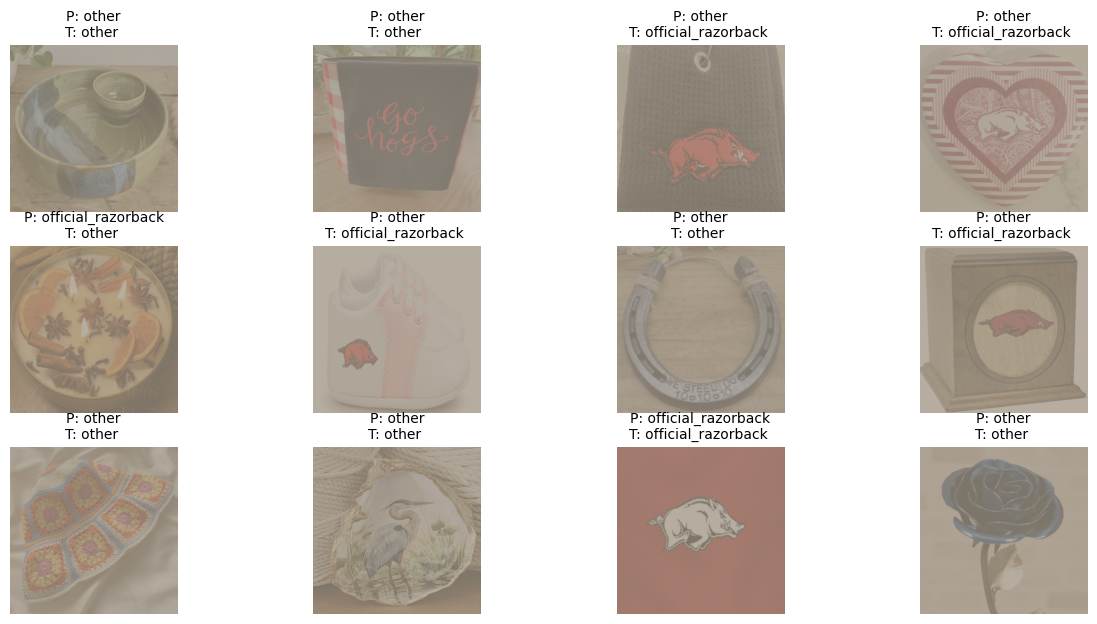

In [48]:
# Carlie
# Function to show images - a second one?
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # C,H,W -> H,W,C
    # Undo normalization if you used it
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")

def show_test_predictions(model, test_loader, classes, num_images=12):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Loop through the batch
            for i in range(images.size(0)):
                if images_shown == num_images:
                    return

                plt.subplot(num_images//4 + 1, 4, images_shown + 1)
                imshow(images[i])

                true_label = classes[labels[i].item()]
                pred_label = classes[preds[i].item()]

                

                plt.title(f"P: {pred_label}\nT: {true_label} ", fontsize=10)
                images_shown += 1

# Call it!
show_test_predictions(model, test_loader, dataset.classes, num_images=12)
plt.show()


In [45]:
# Carlie
# For model WITHOUT normalization
train_loader_no_norm, test_loader_no_norm, num_classes, class_names = make_loaders(use_normalization=False)

# For model WITH normalization
train_loader_norm, test_loader_norm, _, _ = make_loaders(use_normalization=True)


In [47]:
# Carlie
show_test_predictions(
    model_no_norm,
    test_loader_no_norm,
    dataset.classes,
    used_norm=False,
    num_images=12
)
plt.show()

TypeError: show_test_predictions() got an unexpected keyword argument 'used_norm'